In [5]:
import sys
sys.path.append('..')

from transformers import Trainer
from transformers import PatchTSTConfig, PatchTSTPreTrainedModel, PatchTSTModel
import torch
from TimeSeriesJEPA.models.PatchTST import PatchTSTModelJEPA, PatchTSTPredictorModelJEPA
from TimeSeriesJEPA.datasets.mask_utils import apply_masks
from torch.utils.data import DataLoader
from TimeSeriesJEPA.datasets.mask_collator import TimeSeriesMaskCollator
from TimeSeriesJEPA.datasets.time_moe_dataset import TimeMoEDataset
from TimeSeriesJEPA.datasets.time_moe_window_dataset import TimeMoEWindowDataset
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F

In [6]:
context_length = 512
prediction_length=0
patch_size=8
stride=8
pred_mask_scale=(0.15, 0.2)
enc_mask_scale=(0.85, 1)
nenc=1
npred=3
allow_overlap=False
min_keep=5
model_file_path = r"D:\Coursework\MTS\timeseriesJEPA\results\PatchTST_Time300B_sl512_dm64_nh4_el3_fd64_bs256_lr0.0001\checkpoint-14494"

In [7]:
ds = TimeMoEDataset(r'D:\Time_300B', val=True)
windowds = TimeMoEWindowDataset(ds, context_length=context_length, prediction_length=prediction_length)
mask_collator = TimeSeriesMaskCollator(
            seq_len=context_length,
            patch_size=patch_size,
            stride=stride,
            pred_mask_scale=pred_mask_scale,
            enc_mask_scale=enc_mask_scale,
            nenc=nenc,
            npred=npred,
            allow_overlap=allow_overlap,
            min_keep=min_keep,
            )
data_loader = DataLoader(
        windowds,
        batch_size=1,
        shuffle=True,
        num_workers=0,
        drop_last=True,
        collate_fn=mask_collator
        )

before split:  47
after split:  5


100%|██████████| 23304/23304 [00:00<00:00, 952058.72it/s]


In [8]:
encoder_model = PatchTSTModelJEPA.from_pretrained(model_file_path)
target_encoder_model = PatchTSTModelJEPA.from_pretrained(os.path.join(model_file_path, "Target_encoder"))
predictor_model = PatchTSTPredictorModelJEPA.from_pretrained(os.path.join(model_file_path, "Predictor"))

In [9]:
def plot_time_series(data, mask=None, p=None,s=None):
   # Convert tensor to numpy array
   data_np = data.squeeze().numpy()
   time = range(len(data_np))
   plt.figure(figsize=(12, 6))
   plt.plot(time, data_np)
   if mask != None:
      mask = mask.squeeze().numpy()
      for i in mask:
         highlight_range = [i*p, (i*p)+p+1]
         plt.plot(time[highlight_range[0]:highlight_range[1]], 
            data_np[highlight_range[0]:highlight_range[1]], 
            color='red')

   plt.title('Time Series Data')
   plt.xlabel('Time Step')
   plt.ylabel('Value')
   plt.grid(True)
   plt.show()

In [45]:
i = 0
t = 6
for seq_x, label, inputmask, collated_masks_enc, collated_masks_pred in data_loader:
    if i == t:
        break
    i+=1
print("enc mask shape: ", collated_masks_enc[0].shape)
print("pred mask shape: ", collated_masks_pred[0].shape)
print("pred mask shape: ", collated_masks_pred[1].shape)
print("pred mask shape: ", collated_masks_pred[2].shape)

enc mask shape:  torch.Size([1, 1, 43])
pred mask shape:  torch.Size([1, 1, 12])
pred mask shape:  torch.Size([1, 1, 12])
pred mask shape:  torch.Size([1, 1, 12])


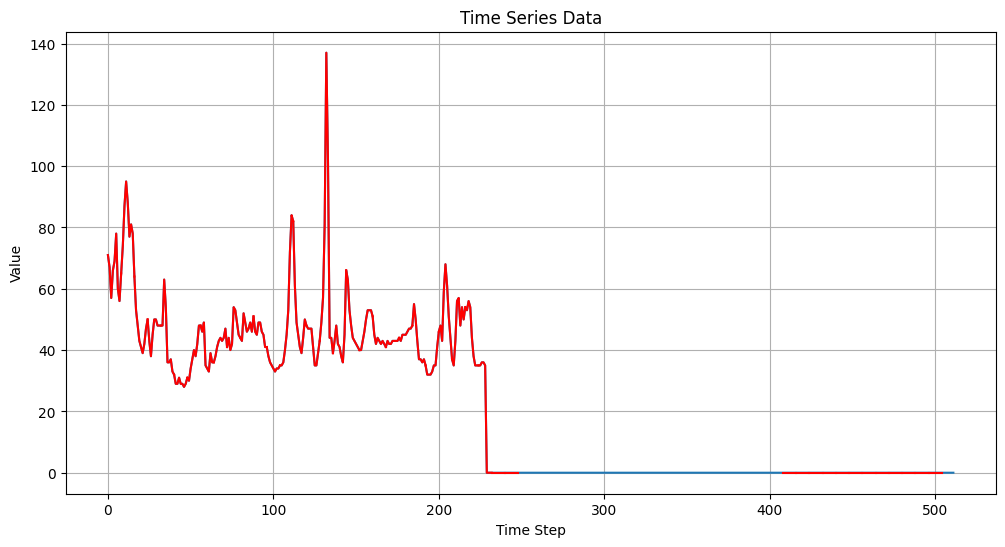

In [46]:
plot_time_series(seq_x, collated_masks_enc[0], p=patch_size)

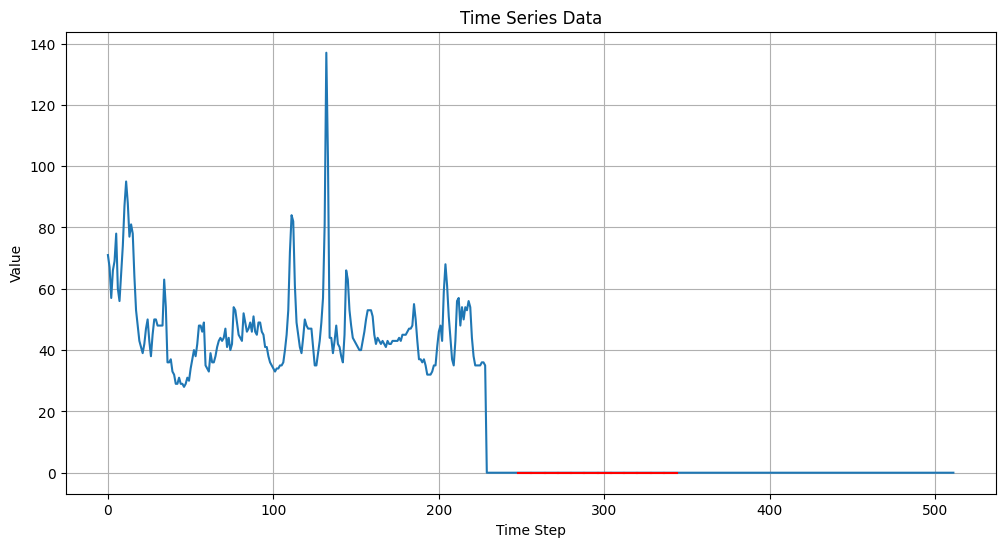

In [47]:
plot_time_series(seq_x, collated_masks_pred[0], p=patch_size)

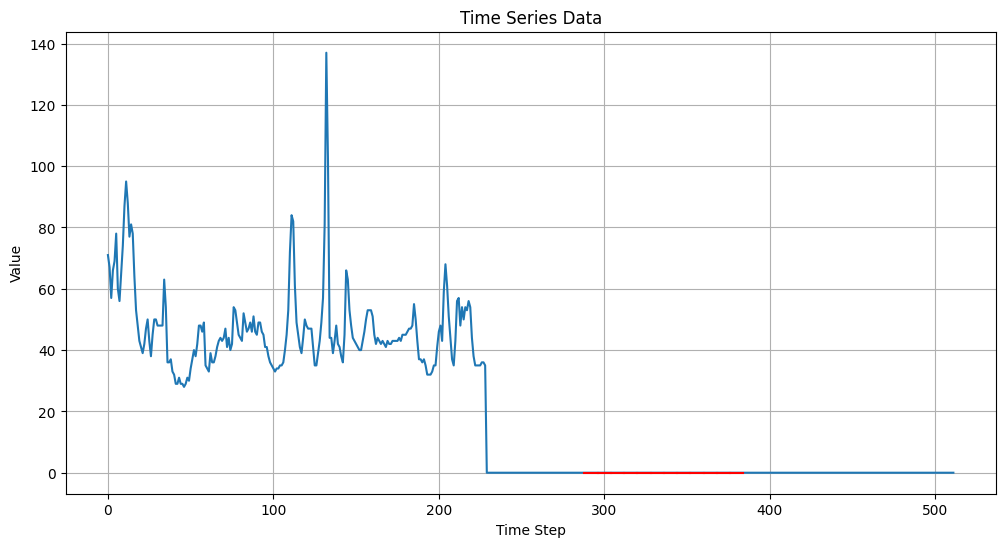

In [48]:
plot_time_series(seq_x, collated_masks_pred[1], p=patch_size)

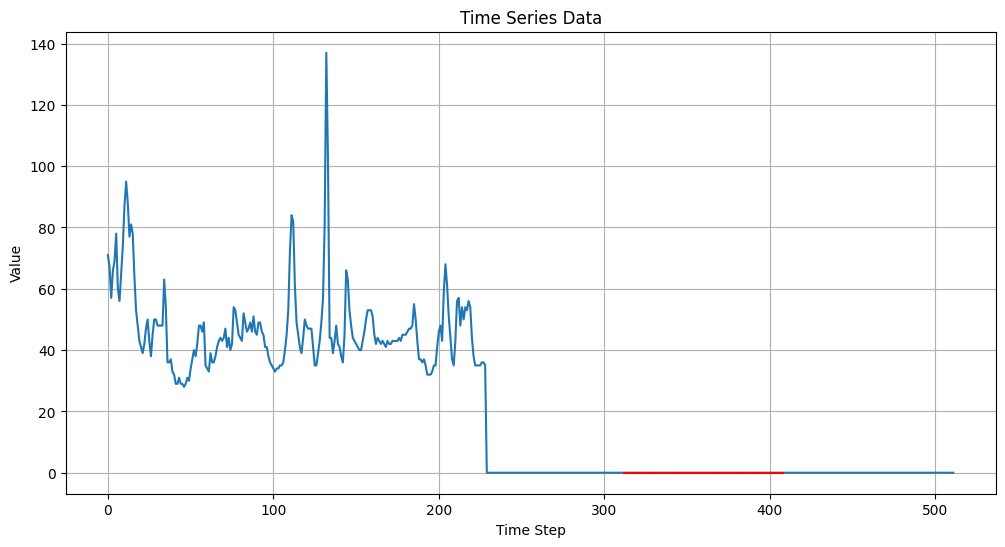

In [49]:
plot_time_series(seq_x, collated_masks_pred[2], p=patch_size)

In [50]:
def forward_context():
    with torch.no_grad():
        encoder_embd = encoder_model(seq_x, collated_masks_enc)
        predictor_embd = predictor_model(encoder_embd[0], collated_masks_enc, collated_masks_pred)
        return encoder_embd[0], predictor_embd[0]

def forward_target():
    with torch.no_grad():
        h = target_encoder_model(seq_x)
        a = F.layer_norm(h[0], (h[0].size(-1),))  # normalize over feature-dim
        B = len(a[0])
        # -- create targets (masked regions of h)
        a = apply_masks(a, collated_masks_pred)
        return h[0], a
def loss_fn(z, h):
    loss = F.mse_loss(z, h)
    return loss

encoder_embd, predictor_embd = forward_context()
full_target_embd, target_embd = forward_target()
loss = loss_fn(predictor_embd, target_embd)

In [51]:
print(loss)

tensor(0.0237)


In [52]:
encoder_embd.shape

torch.Size([1, 1, 43, 64])

In [53]:
predictor_embd.shape

torch.Size([3, 1, 12, 64])

In [54]:
target_embd.shape

torch.Size([3, 1, 12, 64])

In [55]:
print(predictor_embd.norm(dim=3))
print(predictor_embd)

tensor([[[7.6519, 7.6294, 7.5722, 7.5228, 7.4870, 7.4355, 7.4482, 7.5222,
          7.5967, 7.5831, 7.6531, 7.7357]],

        [[7.3832, 7.3956, 7.4739, 7.5545, 7.5485, 7.6229, 7.7031, 7.6735,
          7.6490, 7.6072, 7.5225, 7.5229]],

        [[7.5435, 7.5395, 7.6163, 7.6982, 7.6692, 7.6454, 7.6045, 7.5172,
          7.5092, 7.6518, 7.7565, 7.8200]]])
tensor([[[[-0.0940,  0.8722, -0.6765,  ...,  1.2933, -0.6060,  1.8791],
          [ 0.7010,  0.6732, -0.8059,  ...,  1.0433, -0.5723,  1.8050],
          [ 1.0040, -0.0890, -0.4571,  ...,  1.0579, -0.6790,  1.6965],
          ...,
          [ 0.6288, -1.0739, -1.0943,  ...,  0.6060, -0.5900,  1.4938],
          [-0.3126, -1.3646, -0.8266,  ...,  0.7107, -0.6526,  1.5834],
          [-0.9204, -0.8860, -0.4783,  ...,  0.6421, -0.4993,  1.7815]]],


        [[[-0.5107, -0.4461,  0.5498,  ...,  1.0095, -0.4193,  1.7168],
          [-0.1505,  0.1236,  0.0903,  ...,  0.7080, -0.2760,  1.6709],
          [ 0.4939,  0.2218, -0.5246,  ...,  0.5

In [56]:
print(target_embd.norm(dim=3))
print(target_embd)

tensor([[[8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000,
          8.0000, 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000,
          8.0000, 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000,
          8.0000, 8.0000, 8.0000, 8.0000]]])
tensor([[[[ 0.2242,  0.6684, -0.8924,  ...,  1.0745, -0.6202,  1.6146],
          [ 0.9610,  0.5961, -0.9649,  ...,  0.9261, -0.5683,  1.6280],
          [ 1.3033, -0.0917, -0.5065,  ...,  1.0568, -0.7039,  1.6225],
          ...,
          [ 0.7013, -1.0201, -1.2819,  ...,  0.7823, -0.5932,  1.5714],
          [-0.1975, -1.3116, -0.9136,  ...,  0.9054, -0.6776,  1.6411],
          [-0.9021, -0.8878, -0.4873,  ...,  0.8771, -0.5045,  1.8385]]],


        [[[-0.6727, -0.3744,  0.6529,  ...,  1.0887, -0.4779,  1.7904],
          [-0.3992,  0.3386,  0.1736,  ...,  0.6601, -0.3388,  1.7847],
          [ 0.3645,  0.4429, -0.5262,  ...,  0.4

In [57]:
print(encoder_embd.norm(dim=3))
print(encoder_embd)

tensor([[[7.9241, 7.9115, 7.9303, 7.9200, 7.9260, 7.9483, 7.9391, 7.9460,
          7.9457, 7.9410, 7.9347, 7.9294, 7.9382, 7.9230, 7.9313, 7.9506,
          7.9451, 7.9540, 7.9406, 7.9306, 7.9232, 7.9168, 7.9149, 7.9221,
          7.9183, 7.9200, 7.9221, 7.9196, 7.9391, 7.9437, 7.9397, 7.9269,
          7.9331, 7.9362, 7.9315, 7.9272, 7.9269, 7.9266, 7.9292, 7.9394,
          7.9495, 7.9513, 7.9497]]])
tensor([[[[-1.0727,  1.7105,  0.8893,  ...,  0.8320, -0.9772,  1.0125],
          [-0.1753,  1.3389,  1.3327,  ...,  0.8002, -1.0440,  0.4416],
          [-0.1979,  0.1949,  1.5055,  ...,  0.6463, -1.6026,  0.5270],
          ...,
          [-0.8761, -1.1713,  0.5152,  ...,  1.3203, -0.8275,  1.9285],
          [-1.4994, -0.5636,  0.6059,  ...,  1.3174, -0.7612,  2.0014],
          [-1.2447,  0.3242,  0.0979,  ...,  1.0383, -0.6332,  2.1209]]]])


In [58]:
print(full_target_embd.norm(dim=3))
print(full_target_embd)

tensor([[[7.9285, 7.9146, 7.9359, 7.9274, 7.9315, 7.9494, 7.9478, 7.9518,
          7.9513, 7.9454, 7.9382, 7.9339, 7.9455, 7.9280, 7.9370, 7.9566,
          7.9498, 7.9579, 7.9444, 7.9359, 7.9322, 7.9291, 7.9290, 7.9392,
          7.9349, 7.9301, 7.9320, 7.9339, 7.9502, 7.9550, 7.9526, 7.9469,
          7.9450, 7.9502, 7.9566, 7.9554, 7.9499, 7.9469, 7.9458, 7.9442,
          7.9428, 7.9429, 7.9415, 7.9414, 7.9418, 7.9390, 7.9322, 7.9262,
          7.9246, 7.9245, 7.9256, 7.9328, 7.9457, 7.9502, 7.9467, 7.9392,
          7.9348, 7.9323, 7.9358, 7.9499, 7.9586, 7.9603, 7.9612, 7.9596]]])
tensor([[[[-0.9391,  1.7046,  1.0878,  ...,  0.7307, -1.1877,  0.5107],
          [-0.0672,  1.3830,  1.5758,  ...,  0.8655, -1.2117,  0.0279],
          [-0.1103,  0.2388,  1.6338,  ...,  0.5354, -1.6933,  0.0948],
          ...,
          [-1.6480, -0.5773,  0.8892,  ...,  1.4000, -0.9749,  1.3355],
          [-1.4298,  0.2549,  0.2906,  ...,  1.1180, -0.8281,  1.3608],
          [-0.5447,  0.5146, -